# RADI 6060 Homework 4 (Final)
#### Gweneth Andersen
#### 4/29/2024

## Monte Carlo Calculation of Energy Deposition Rate for Tri-energetic Photon Beam in a Semi-infinite Water-equivalent Parallelepiped

In this notebook, a Monte Carlo algorithm is used to simulate photoelectric absorption of 15 keV, 20 keV, and 30 keV photons from a plane-parallel pencil beam incident on a slab of purely absorbing material with water-like photoelectric absorption cross-sections. In this problem, the slab is taken to be infinite in two dimensions (y and z), but bounded in the x dimension at x = 0 cm (infinitely extending in the +x direction). The photoelectric absorption cross-sections and relative abundance of photons of each energy in the beam are shown in Table 1, and the geometry of the beam and slab are shown in Figure 1. *(Figure and Table reproduced from assignment.)*

![figure1.png](Figure1.png)

## Utilities

A class **Medium** is defined to access the linear attenuation properties of the slab. As the slab is a purely absorbing medium, scattering cross-sections for all energies are equal to zero cm<sup>-1</sup>.

In [87]:
class Medium():
    def __init__(self, xs: dict):
        self.xs = xs
        self.xs_a = self.xs["xs_a"]
        self.xs_s = self.xs["xs_s"]
        self.xs_total = {energy: self.xs_a[energy] + self.xs_s[energy] for energy in self.xs_a.keys()} # total attenuation cross-section
    
water_xs = {
    "xs_a": {
        15.0: 1.369, # cm^-1
        20.0: 5.439 * 10**-1, # cm^-1
        30.0: 1.458 * 10**-1 # cm^-1
    },
    "xs_s": {
        15.0: 0, # cm^-1
        20.0: 0, # cm^-1
        30.0: 0 # cm^-1
    }
}

water = Medium(water_xs)

Pseudo-random numbers for the Monte Carlo simulation are computed by the multiplicative congruential generator algorithm for consistency.

The **MultiplicativeCongruentialGenerator** class is initialized with a multiplier $I_{1}$, a modulus $M$, and an initial seed $R_{0} ∈ [0, M)$. New pseudo-random numbers (seeds) $R_{n}$ are computed by the following relation:

$$R_{n} = (I_{1} * R_{n-1}) \% M$$

For simplicity, the default values of these parameters are as follows:

$$I_{1} = 7^{5}$$
$$M = 2^{31} - 1$$
$$R_{0} = \frac{1}{2}M$$

The method *generateNext()* computes the next number in the sequence and stores it in the object's list of seeds. It then maps this seed to a pseudo-random number between 0 and 1 by computing the ratio of the new seed to the modulus, stores and returns that number.

The method *generateNextN()* repeats this process $N$ times.

In [ ]:
# random number generator using the multiplicative congruential algorithm
class MultiplicativeCongruentialGenerator():
    def __init__(self, initialSeed: int = None, I1: int = 7**5, M: int = 2**31 - 1): 
        self.multiplier = I1
        self.modulus = M
        if initialSeed is None:
            initialSeed = int(self.modulus / 2)
        self.seed = initialSeed % self.modulus
        self.randomNumber = self.seed / self.modulus
        self.seeds = [self.seed]
        self.randomNumbers = [self.randomNumber]
    
    # generate and return the next random number in the multiplicative congruential sequence
    def generateNext(self):
        newSeed = (self.multiplier * self.seed) % self.modulus
        self.seed = newSeed
        self.seeds.append(self.seed)
        newRandomNumber = newSeed / self.modulus
        self.randomNumber = newRandomNumber
        self.randomNumbers.append(self.randomNumber)
        return newRandomNumber
    
    # generate N more random numbers and return them in a list
    def generateNextN(self, N: int):
        newRandomNumbers = []
        for i in range(N):
            newRandomNumber = self.generateNext()
            newRandomNumbers.append(newRandomNumber)
        return newRandomNumbers
    
MCG = MultiplicativeCongruentialGenerator()

## Simulator

The Monte Carlo algorithm is implemented in a **Simulator** class which is initialized with a random number generator (**MCG**) and an interaction medium (**water**).

The simulation is performed by calling the *simulate()* method, whose arguments are the number of histories to run $N_{histories}$ and the list of upper edge positions for bins $x$.

First, *simulate()* checks whether the simulator has its bin-related parameters—$bin\_edges$, $bin\_widths$, and $bin\_scores$—defined yet. If they are empty, the helper method *setBins()* is called, with the $x$ argument passed to it. This method initializes $bin\_edges$ by mapping the list of upper bin edges to a list of 2-tuples, where each tuple contains the lower and upper edges of a bin, starting with the pair $(0, x_{0})$, where $x_{0}$ is the first element of $x$. Then, $bin\_widths$ is initialized as a list of widths of these bins, computed as the difference between upper and lower edges. Finally, $bin\_scores$ is initialized as a dictionary whose keys are the tuples in $bin\_edges$ and whose values are nested dictionaries containing a $'count'$ key (which tracks the total number of photons absorbed in the bin and an $'energy'$ key. The value for $'energy'$ in each case is a third nested dictionary that tracks the total quantity of energy deposited in the bin by photons of each energy in the beam, so its keys are the energies $15.0$ (keV), $20.0$ (keV), and $30.0$ (keV). The values for all three, as well as $'count'$, are all initialized to zero. This structure enables an indexable calculation of the number of photons of each energy by dividing the total energy deposited from each source by the source energy.

Next, *simulate()* begins the history loop. At the beginning of each history, a source energy is sampled by calling the *sampleSourceEnergy()* method, which generates a random number and uses it to select an energy from bins defined by the beam fractions in Table 1. If the random number is less than or equal to $0.28$, then 15 keV is chosen; else, if it is greater than $0.28$ but less than or equal to $0.28 + 0.5 = 0.78$, then 20.0 keV is chosen; finally, if it is between $0.78$ and $1.0$, then 30.0 keV is chosen.

The sampled source energy is then passed to the *sampleCollisionDistance()* method, which generates a new random number $R$ and computes the depth $x$ in the medium at which the current photon is absorbed. For convenience, the initial $x$ coordinate of the photon is taken to be 0 cm. The distance is derived from the collisional PDF $f(x)$, whereby its integral, the CDF $F(x)$, is set equal to $R$. Since the medium is a pure absorber, the total cross-section $Σ_{t} = Σ_{a}$ from Table 1.

$$f(x) = Σ_{t}e^{-Σ_{t}x}$$
$$F(x) = e^{-Σ_{t}x} = R$$
$$x = -\frac{1}{Σ_{t}}ln(R)$$

To determine the bin, if any, in which the collision occurs, *simulate()* iterates over the tuples in $bin\_edges$ and compares $x$ to the upper edge. Whenever a bin is found for which $x$ is less than the upper edge, the $'count'$ value for that bin in $bin\_scores$ is incremented by 1 and the $'energy'$ value for the chosen energy in that bin is increased by an amount equal to the energy. Then, the loop is broken to save time and prevent scoring in successive bins.

The methods *computeDeposition()*, *computeUncertainties()*, and *computeRelativeStandardDeviations()* assist the user with analysis of the scoring results. The *computeDeposition()* method returns a sequence of energy deposition rates per history in units of $keV cm^{-1} photon^{-1}$ for only one energy, but the values can be stored and summed during analysis to assess the overall energy deposition rate spectrum of the composite beam. Values are in 1-to-1 correspondence with the bins. The method iterates over $bin\_scores$ and $bin\_widths$ simultaneously, calculating the result for each bin by the following formula, where $Δx_{j}$ is the width of a given bin and $ΔE_{j}(E)$ is the amount of energy deposited by photons of the given energy. The symbol $D$ is used for energy deposition rate because, for this water-equivalent medium with linear density $ρ = 1 \frac{g}{cm}$, it is equivalent to dose.

$$D_{j}(E) = \frac{ΔE_{j}(E)}{N * Δx}$$

Variances $S_{j}^{2}$ for energy deposition rates in bins were computed using the definition of variance:

$$S_{j}^{2} = \frac{1}{N - 1} \Biggl[ \sum \limits _{j=1} ^{N} (E_{j} - \bar{E}_{j})^{2} \Biggr]$$

Here, $E_{j}$ is the energy scored in the bin during that history, and $\bar{E}_{j}$ is the mean score for the bin over all histories. When computing variances piecewise for each individual energy, $E_{j}$ only ever takes values of 0.0 keV or $E$, depending on the sampled source energy, where $E$ may be either 15.0 keV, 20.0 keV, or 30.0 keV; whereas $\bar{E}_{j}$ takes values between 0 and 30.0 keV and is computed as the total score for the given energy in the given bin divided by the number of histories. This simplifies the sum to two components, one for the $N_{E}$ histories where the score is $E$ and another for the histories where the score is 0.0 keV.

$$S_{j}^{2} = \frac{1}{N - 1} \Biggl[ N_{E}(E - \bar{E}_{j})^{2}) + (N - N_{E})\bar{E}_{j}^{2} \Biggr]$$

For convenience, an optional boolean $total$ flag is added as an argument for *computeUncertainties()* which, when $True$, instead returns the version of the sum that contains all possible scores:

$$S_{j}^{2} = \frac{1}{N - 1} \Biggl[ N_{15.0 keV}(15.0 keV - \bar{E}_{j})^{2} + N_{20.0 keV}(20.0 keV - \bar{E}_{j})^{2} + N_{30.0 keV}(30.0 keV - \bar{E}_{j})^{2} + (N - N_{15.0 keV} - N_{20.0 keV} - N_{30.0 keV})\bar{E}_{j}^{2} \Biggr]$$

Monte Carlo estimates are reported as $\hat{E}_{j} ± \hat{\sigma}_{j}$, where $\hat{E}_{j}$ is the mean energy deposition rate (equal to $\bar{E}_{j}$) and $\hat{\sigma}_{j}$ is the relative standard deviation:

$$\sigma_{j} = \sqrt{\frac{S_{j}^{2}}{N}}$$

$$\hat{\sigma}_{j} = \frac{\sigma_{j}}{\hat{E}_{j}}$$

The *computeRelativeStandardDeviations()* method computes $\hat{\sigma}_{j}$ values by calling *computeUncertainties()* to generate variances and then applying the above formula.

In [61]:
import numpy as np
import math

class Simulator():
    def __init__(self, medium: Medium, rng: MultiplicativeCongruentialGenerator):
        self.medium = medium
        self.rng = rng
        self.bin_edges = []
        self.bin_widths = []
        self.bin_scores = {}
        
    def sampleSourceEnergy(self):
        R = self.rng.generateNext()
        if R <= 0.28:
            return 15.0
        elif R <= 0.78:
            return 20.0
        else:
            return 30.0
        
    def sampleCollisionDistance(self, E: float):
        R = self.rng.generateNext()
        collision_distance = -np.log(R) / self.medium.xs_total[E] # cdf(x) = R
        return collision_distance
        
    def setBins(self, x: list):
        self.bin_edges = [(0, x[0])] + [(x[i], x[i+1]) for i in range(len(x) - 1)]
        self.bin_widths = [round(edges[1] - edges[0], 3) for edges in self.bin_edges]
        self.bin_scores = {edges: {'count': 0, 'energy': {15.0: 0, 20.0: 0, 30.0: 0}} for edges in self.bin_edges}
    
    def simulate(self, N_histories: int, x: list):
        if len(self.bin_edges) == 0 or len(self.bin_widths) == 0 or len(self.bin_scores) == 0:
            self.setBins(x)
        for i in range(N_histories):
            source_energy = self.sampleSourceEnergy()
            collision_distance = self.sampleCollisionDistance(source_energy)
            for bin_ in self.bin_edges:
                if collision_distance < bin_[1]:
                    self.bin_scores[bin_]['energy'][source_energy] += source_energy
                    self.bin_scores[bin_]['count'] += 1
                    break
    
    def computeDeposition(self, N_histories: int, E: float):
        dep = []
        for score, dx in zip(self.bin_scores.values(), self.bin_widths):
            if score['count'] > 0 and dx != 0:
                dep.append(score['energy'][E]/(N_histories*dx))
            else:
                dep.append(0)
        return dep
    
    def computeUncertainties(self, N_histories: int, E: float=None, total: bool=False):
        if total and E is None:
            unc = []
            for score in self.bin_scores.values():
                bin_total = sum(score['energy'].values())
                E_counts = {E_: score['energy'][E_]/E_ for E_ in score['energy'].keys()} # counts for each energy in this bin
                bin_mean = bin_total / N_histories
                variance = (1 / (N_histories - 1)) * (
                    sum([
                        count * (E_ - bin_mean)**2 for E_, count in E_counts.items()
                    ])
                    + (N_histories - score['count']) * (bin_mean**2) # all histories with no event
                )
                unc.append(variance) # append the variance for this bin
            return unc
        elif E is not None:
            unc = []
            for score in self.bin_scores.values():
                E_bin_total = score['energy'][E]
                E_count = E_bin_total / E # count for this energy in this bin
                E_bin_mean = E_bin_total / N_histories
                variance = (1 / (N_histories - 1)) * (
                    E_count * (E - E_bin_mean)**2
                    + (N_histories - E_count) * (E_bin_mean**2) # all histories with no event or different energy event
                )
                unc.append(variance) # record variance for this bin
            return unc
        else:
            return [0]*len(self.bin_edges)
        
    def computeRelativeStandardDeviations(self, N_histories: int, E: float=None, total: bool=False):
        if total and E is None:
            unc = self.computeUncertainties(N_histories, total=True)
            std = []
            for i, score in enumerate(self.bin_scores.values()):
                bin_total = sum(score['energy'].values())
                bin_mean = bin_total / N_histories
                std_ = math.sqrt(unc[i] / N_histories) / bin_mean if bin_mean != 0 else 0 # normalize to bin mean
                std.append(std_)
            return std
        elif E is not None:
            unc = self.computeUncertainties(N_histories, E)
            std = []
            for i, score in enumerate(self.bin_scores.values()):
                E_bin_total = score['energy'][E]
                E_bin_mean = E_bin_total / N_histories
                std_ = math.sqrt(unc[i] / N_histories) / E_bin_mean if E_bin_mean != 0 else 0 # normalize to bin mean
                std.append(std_)
            return std
        else:
            return [0]*len(self.bin_edges)

## Results

A logarithmic sequence of 10 bins were generated for the energy deposition rate calculations, with the first bin $(0 cm, 0.05 cm)$ and successive bins doubling in width. For each of four $N_{histories}$ (2,000, 20,000, 200,000, and 60,000,000), a figure was generated containing subplots for $D$ on lin-log axes, $D$ on log-log axes, and the normalized counts per history in each bin on lin-lin axes. The counts spectra were computed on 100 evenly spaced 0.1 cm wide bins. In each figure, partial spectra for 15.0 keV, 20.0 keV, and 30.0 keV were plotted alongside the spectrum for the full beam. Additionally, the analytical solution for exponential attenuation (Beer's law, below) was plotted to compare simulated bin counts to theory.

$$\frac{N(x)}{N_{histories}} = \frac{N_{0}}{N_{histories}}e^{-Σ_{t}x}$$

Results for 2000 histories:
	15.0 keV min stdv: 0
	15.0 keV max stdv: 0.4996246715347463
	20.0 keV min stdv: 0
	20.0 keV max stdv: 0.19488593773256552
	30.0 keV min stdv: 0.0931592789379116
	30.0 keV max stdv: 0.4996246715347463
	All energies min stdv: 0.0931592789379116
	All energies max stdv: 0.4996246715347463
Results for 20000 histories:
	15.0 keV min stdv: 0
	15.0 keV max stdv: 1.0
	20.0 keV min stdv: 0.018738748673285188
	20.0 keV max stdv: 0.4081972536857181
	30.0 keV min stdv: 0.029698662423336766
	30.0 keV max stdv: 0.1426856027227952
	All energies min stdv: 0.029698662423336766
	All energies max stdv: 0.1426856027227952
Results for 200000 histories:
	15.0 keV min stdv: 0
	15.0 keV max stdv: 0.3779588034712626
	20.0 keV min stdv: 0.006016072533886697
	20.0 keV max stdv: 0.10257372176301136
	30.0 keV min stdv: 0.009529607921823974
	30.0 keV max stdv: 0.04153447281223794
	All energies min stdv: 0.009529607921823974
	All energies max stdv: 0.04153447281223794
Results for 60000000

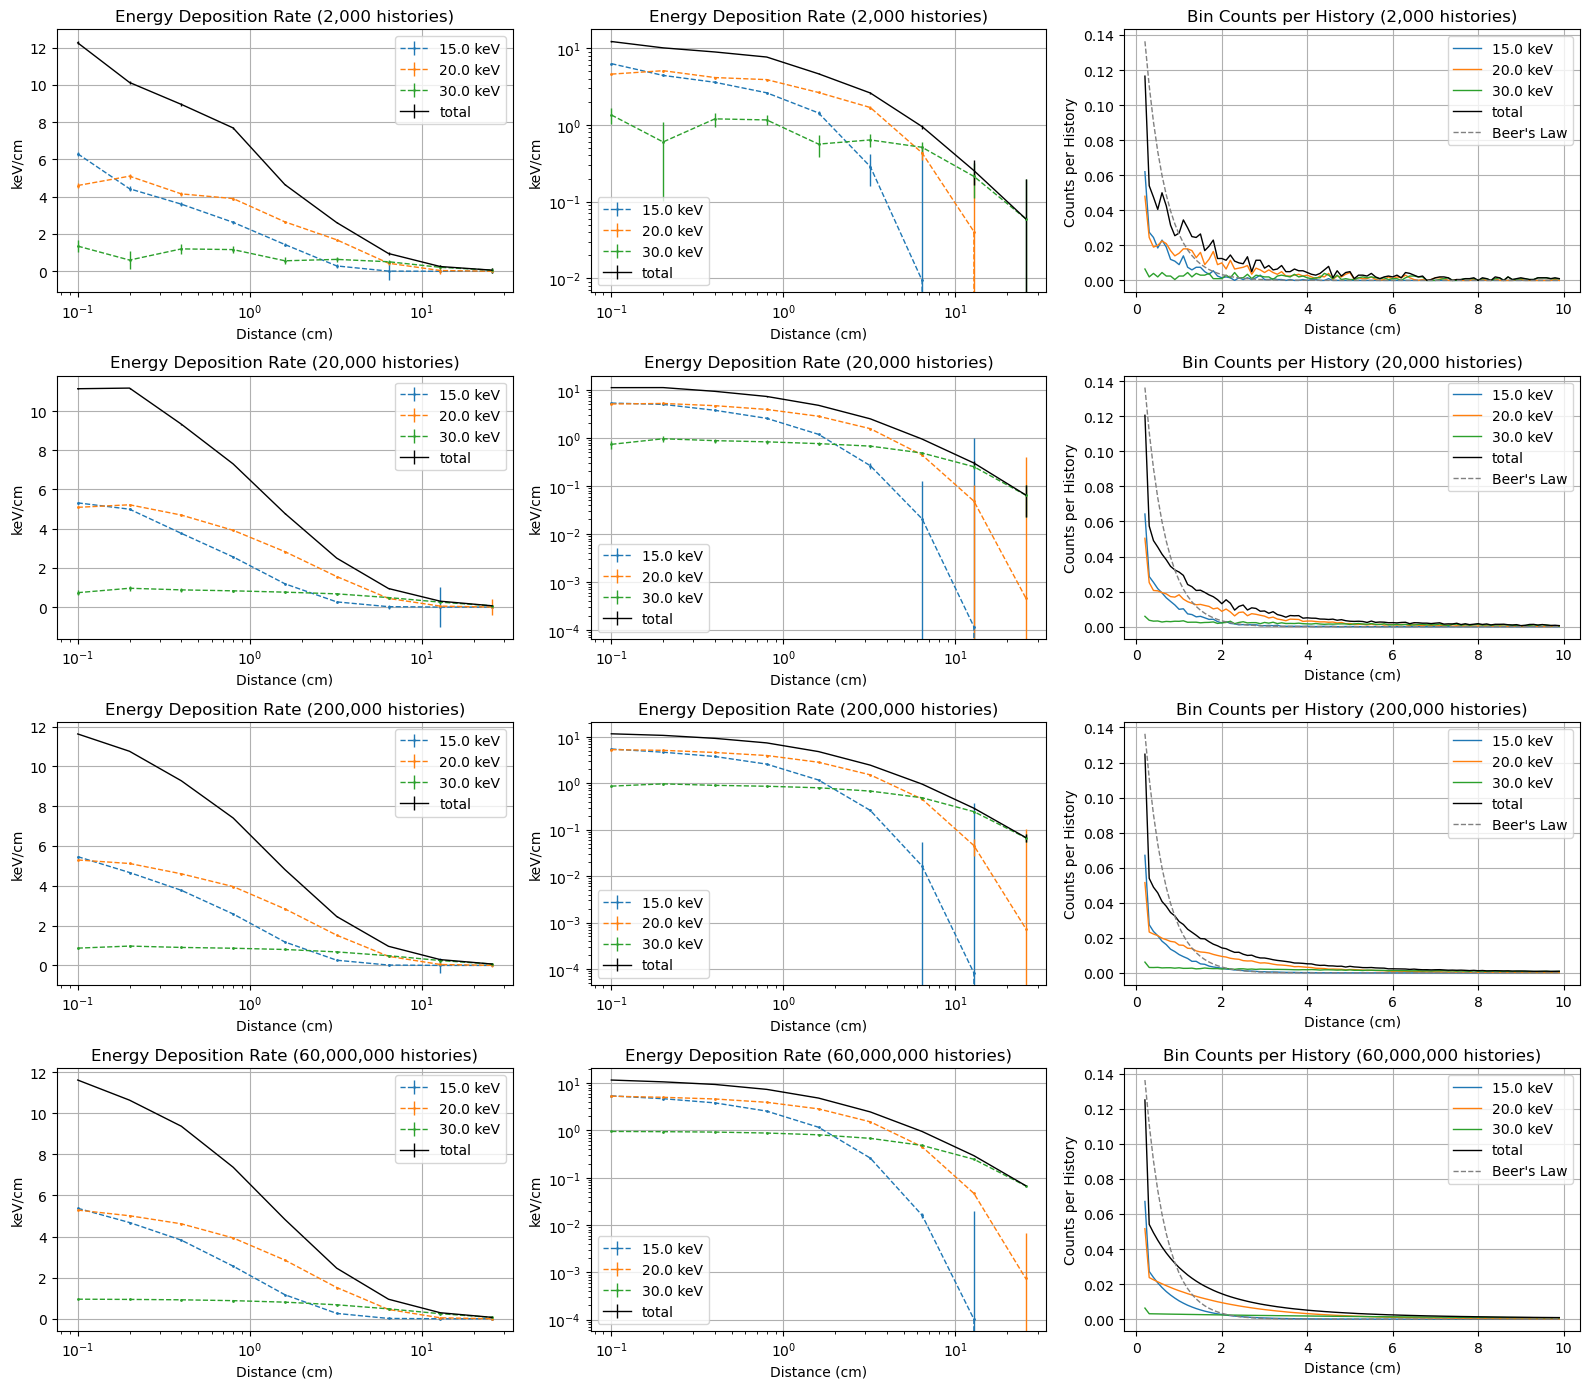

In [85]:
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale

x = [0.05 * 2**i for i in range(10)]
x_lin = [0.1*i for i in range(1, 100)]
xs_total = sum([xs for xs in water.xs_total.values()])
beer_law = lambda x: 0.1 * xs_total * np.exp(-x*xs_total)

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16,14))
axs = [a[0] for a in ax]
axslog = [a[1] for a in ax]
axsexp = [a[2] for a in ax]

for j, N in enumerate([2*10**3, 2*10**4, 2*10**5, 6*10**7]):
    print("Results for {} histories:".format(N))
    sim = Simulator(water, MCG)
    sim.simulate(N_histories=N, x=x[1:])
    simlin = Simulator(water, MCG)
    simlin.simulate(N_histories=N, x=x_lin[1:])
    d_total = [0]*len(x[1:])
    for E in [15.0, 20.0, 30.0]:
        d = sim.computeDeposition(N, E)
        std = sim.computeRelativeStandardDeviations(N, E)
        print("\t{} keV min stdv: {}".format(E, min(std)))
        print("\t{} keV max stdv: {}".format(E, max(std)))
        for i in range(len(d_total)):
            d_total[i] += d[i]
        axs[j].errorbar(x[1:], d, yerr=std, linestyle='--', markersize=1, lw=1, marker='o', label="{} keV".format(E))
        axslog[j].errorbar(x[1:], d, yerr=std, linestyle='--', markersize=1, lw=1, marker='o', label="{} keV".format(E))
        axsexp[j].plot(x_lin[1:], [score['energy'][E]/(E*N) for score in simlin.bin_scores.values()], linestyle='-', lw=1, label="{} keV".format(E))

    std_total = sim.computeRelativeStandardDeviations(N, total=True)
    print("\tAll energies min stdv: {}".format(min(std)))
    print("\tAll energies max stdv: {}".format(max(std)))
    axs[j].errorbar(x[1:], d_total, yerr=std_total, linestyle='-', markersize=1, lw=1, color="k", label="total")
    axslog[j].errorbar(x[1:], d_total, yerr=std_total, linestyle='-', markersize=1, lw=1, color="k", label="total")
    axsexp[j].plot(x_lin[1:], [score['count']/N for score in simlin.bin_scores.values()], linestyle='-', lw=1, color="k", label="total")
    beer = [beer_law(x_) for x_ in x_lin[1:]]
    axsexp[j].plot(x_lin[1:], beer, linestyle='--', lw=1, color="gray", label="Beer's Law")

    axs[j].set_xscale(LogScale("x", base=10))
    axslog[j].set_xscale(LogScale("x", base=10))
    axslog[j].set_yscale(LogScale("y", base=10))
    axs[j].set_xlabel("Distance (cm)")
    axslog[j].set_xlabel("Distance (cm)")
    axsexp[j].set_xlabel("Distance (cm)")
    axs[j].set_ylabel("keV/cm")
    axslog[j].set_ylabel("keV/cm")
    axsexp[j].set_ylabel("Counts per History")
    axs[j].set_title("Energy Deposition Rate ({:,} histories)".format(N))
    axslog[j].set_title("Energy Deposition Rate ({:,} histories)".format(N))
    axsexp[j].set_title("Bin Counts per History ({:,} histories)".format(N))
    axs[j].legend(loc='upper right')
    axslog[j].legend(loc='lower left')
    axsexp[j].legend(loc='upper right')
    axs[j].grid()
    axslog[j].grid()
    axsexp[j].grid()
    
fig.tight_layout()
plt.savefig("hw4_plots.png")
plt.show()

## Discussion

In the limit of increasing number of histories, the maximum energy deposition rate and bin counts for the full beam and all individual energies occurred at the minimum depth, with the full beam having a maximum energy deposition rate of 11.62 keV/cm and maximum normalized bin count of 0.137 photons per history. The full beam's energy deposition rate was halved before reaching 1.6 cm depth, and had fallen below 1.0 keV/cm by 6.4 cm depth. The energy deposition rate curves for 15.0 keV and 20.0 keV photons each constituted almost half of the beam total at first, with the 15.0 keV rate declining more rapidly as those photons were more likely to be attenuated at shallower depths. The 30.0 keV curve started at 0.952 keV/cm and, conversely, declined more slowly than the others, eventually exceeding the 15.0 keV curve at around 2 cm depth and exceeding the 20.0 keV curve at around 6 cm depth. Bin count spectra closely resembled Beer's law.